In [1]:
import itertools
import json
import os
import re
import sqlite3
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.stretch'] = 'condensed'

In [2]:
## CHANGE IF NECESSARY
DB_PATH = os.path.expanduser('~/webform-data.db')

db_uri = Path(DB_PATH).absolute().as_uri() + '?mode=ro'
con = sqlite3.connect(db_uri, uri=True)

In [3]:
cur = con.execute('''
    SELECT ranking, domain, content_categories
    FROM domain_info di
    INNER JOIN tranco_list tl USING (domain)
''')

rows = set()
id2category = {-1: 'Unknown'}
id2parent = {-1: -1}

for row in cur:
    ranking, domain, content_categories_json = row

    content_categories = json.loads(content_categories_json)

    for item in content_categories:
        id2category[item['id']] = item['name']

        if 'super_category_id' in item:
            id2parent[item['id']] = item['super_category_id']
            rows.add((ranking, domain, item['id'], item['super_category_id']))

    if len(content_categories) == 0:
        rows.add((ranking, domain, -1, -1))

df_domain = pd.DataFrame(list(rows), columns=['ranking', 'domain', 'category_id', 'super_category_id'])
df_domain['category'] = df_domain['category_id'].map(id2category)
df_domain['super_category'] = df_domain['super_category_id'].map(id2category)
df_domain.set_index('domain', inplace=True)
df_domain.sort_index(inplace=True)

# Take parent category for some website categories
df_domain['website_category'] = df_domain['category']
df_domain.loc[df_domain.super_category == "Government & Politics", "website_category"] = 'Government & Politics'
df_domain.loc[df_domain.super_category == "Health", "website_category"] = 'Health'
df_domain.loc[df_domain.super_category == "Shopping & Auctions", "website_category"] = 'Shopping & Auctions'
df_domain.loc[df_domain.super_category == "Society & Lifestyle", "website_category"] = 'Society & Lifestyle'
df_domain.loc[df_domain.super_category == "Internet Communication", "website_category"] = 'Internet Communication'

df_domain_category = df_domain.groupby('domain').agg({'website_category': frozenset})

In [4]:
cur = con.execute('''
    SELECT domain, job_hash, form_filename, form_type, field_list
    FROM form_classification a
         INNER JOIN field_classification b
         USING (domain, job_hash, form_filename)
''')

ID_TYPES = {"Address", "EmailAddress", "GovernmentId", "BankAccountNumber", "PersonName", "PhoneNumber", "UsernameOrOtherId", "TaxId"}
unique_records = defaultdict(set)
web_form_count = 0

for row in cur:
    domain, job_hash, form_filename, form_type, field_list_json = row

    field_list = json.loads(field_list_json)

    if ID_TYPES.isdisjoint(field_list):
        continue

    web_form_count += 1
    unique_records[domain, form_type].update(field_list)

df_forms = pd.DataFrame([[*t, frozenset(l)] for t, l in unique_records.items()], columns=['domain', 'form_type', 'data_type'])
df_forms = df_forms.join(df_domain_category, on='domain', how='outer').reset_index(drop=True)
df_forms.loc[df_forms.data_type.isna(), 'data_type'] = frozenset()

## Availability

In [5]:
# Domains with forms (Section 6.1)
n_total_domains = df_forms.domain.nunique()
n_domains_with_forms = df_forms[~df_forms.form_type.isna()].domain.nunique()
n_domains_with_forms

10143

In [6]:
cur = con.execute('''
    SELECT DISTINCT domain, url FROM privacy_policy_link
    INNER JOIN form_classification USING (domain, job_hash, form_filename)
    LEFT JOIN privacy_policy_link_normalized USING (url)
''')

domain_has_pp = {}

for domain, url in cur:
    domain_has_pp.setdefault(domain, False)
    domain_has_pp[domain] |= (url is not None)

assert len(domain_has_pp) == n_domains_with_forms

df = df_domain_category[df_domain_category.index.isin(domain_has_pp)].copy()
df['has_privacy_policy'] = df.index.map(domain_has_pp)

In [7]:
# Websites w/o privacy policy, by website category (Table 5)

SELECTED_WEBSITE_CATEGORIES = """
Educational Institutions
Government & Politics
Internet Communication
Economy & Finance
Video Streaming
Gaming
News & Media
Travel
Health
Society & Lifestyle
Shopping & Auctions
""".strip().split('\n')

for category in SELECTED_WEBSITE_CATEGORIES + ['All Categories']:
    if category == 'All Categories':
        subset = df
    else:
        subset = df[df.website_category.apply(lambda s: category in s)]

    no_policy_count = (~subset.has_privacy_policy).sum()
    print(
        f"{category.replace('&', chr(92) + '&'):24s}",
        '&',
        f"{no_policy_count:3d}",
        '&',
        "({:4.2f}\\% of {:,d})".format(no_policy_count / len(subset) * 100, len(subset)),
        end=' \\\\\n',
    )

Educational Institutions &  53 & (10.37\% of 511) \\
Government \& Politics   &  82 & (10.00\% of 820) \\
Internet Communication   &  56 & (8.00\% of 700) \\
Economy \& Finance       &  23 & (5.07\% of 454) \\
Video Streaming          &  20 & (4.37\% of 458) \\
Gaming                   &  12 & (3.81\% of 315) \\
News \& Media            &  29 & (3.48\% of 834) \\
Travel                   &  11 & (3.75\% of 293) \\
Health                   &  13 & (3.17\% of 410) \\
Society \& Lifestyle     &  23 & (2.62\% of 878) \\
Shopping \& Auctions     &  18 & (1.99\% of 903) \\
All Categories           & 584 & (5.76\% of 10,143) \\


In [8]:
# Domains with privacy policies (Section 6.1)

n_domain_with_pp = df[df.has_privacy_policy].index.nunique()

print(n_domain_with_pp, n_domain_with_pp / n_domains_with_forms * 100)

9559 94.24233461500542


## Availability -- Form Level (Section 6.1)

In [9]:
cur = con.execute('''
    SELECT domain, form_type, scope
    FROM form_classification fc
         INNER JOIN privacy_policy_link pp USING (domain, job_hash, form_filename)
''')

pp_availability = {}
all_scopes = ['FORM', 'PAGE', 'PARENT', 'UNKNOWN']

for row in cur:
    domain, form_type, scope = row
    old_scope = pp_availability.get((domain, form_type), 'UNKNOWN')

    if form_type == 'Unknown':
        continue

    if all_scopes.index(scope) <= all_scopes.index(old_scope):
        pp_availability[domain, form_type] = scope

df_pp_availability = pd.DataFrame(pp_availability.keys(), columns=['domain', 'form_type'])
df_pp_availability['location'] = df_pp_availability.apply(lambda x: pp_availability[x.domain, x.form_type], axis=1)
df_pp_availability['location_id'] = df_pp_availability.location.map(lambda x: all_scopes.index(x))

In [10]:
# Num. websites that include pp links inside the form, by form type (Table 6)

for form_type in [
    'Account Registration Form',
    'Payment Form',
    'Financial Application Form',
    'Subscription Form',
    'Role Application Form',
    'Contact Form',
    'Reservation Form',
    'Content Submission Form',
    'Account Login Form',
    'Account Recovery Form',
]:
    subset = df_pp_availability[df_pp_availability.form_type == form_type]

    n_domain = subset.domain.nunique()
    n_inform = subset[subset.location == 'FORM'].domain.nunique()
    rate = n_inform / n_domain * 100.0

    print(
        f"{form_type[:-5]:22}",
        f"{n_inform:5,}",
        f'({rate:.2f}\\% of {n_domain:,})',
        sep=' & ', end=' \\\\\n',
    )

Account Registration   & 2,309 & (44.94\% of 5,138) \\
Payment                &   401 & (36.59\% of 1,096) \\
Financial Application  &    59 & (33.71\% of 175) \\
Subscription           & 1,491 & (32.32\% of 4,613) \\
Role Application       &   299 & (31.18\% of 959) \\
Contact                & 1,783 & (28.28\% of 6,304) \\
Reservation            &    82 & (19.85\% of 413) \\
Content Submission     &   124 & (14.92\% of 831) \\
Account Login          &   772 & (10.78\% of 7,159) \\
Account Recovery       &   210 & (4.16\% of 5,054) \\


## Content Analysis (Section 6.2)

In [11]:
cur = con.execute('''
    SELECT domain, normalized_url FROM privacy_policy_link
        INNER JOIN privacy_policy_link_normalized USING (url)
''')

domain_to_pp_url_list = defaultdict(set)

for domain, url in cur:
    if url:
        domain_to_pp_url_list[domain].add(url)

domain_to_pp_url_list = {k: frozenset(v) for k, v in domain_to_pp_url_list.items()}

df_pp = df_domain_category[df_domain_category.index.isin(domain_to_pp_url_list)].copy()
df_pp['privacy_policy_urls'] = df_pp.index.map(domain_to_pp_url_list)

In [12]:
cur = con.execute('''
    SELECT url, disclosures FROM privacy_policy_disclosures
''')

url_to_data_types = {}

for url, disclosures in cur:
    disclosures = json.loads(disclosures)
    url_to_data_types[url] = frozenset(disclosures.keys())

df_pp['data_types'] = df_pp.privacy_policy_urls.map(
    lambda urls: frozenset(itertools.chain.from_iterable(url_to_data_types.get(url, []) for url in urls))
)
df_pp = df_pp[df_pp.data_types.map(len) > 0]

In [13]:
df_website_data_types = df_forms[~df_forms.form_type.isna()].groupby('domain').agg({
    'website_category': 'first',
    'data_type': lambda s: frozenset.union(*s)
})

df = df_pp.join(df_website_data_types[['data_type']], on='domain', how='inner').rename({'data_type': 'data_types_collected'}, axis=1)

df

,website_category,privacy_policy_urls,data_types,data_types_collected
domain,,,,
1001fonts.com,(Society & Lifestyle),"(https://accounts.google.com/TOS, https://www....","(PersonName, EmailAddress)","(EmailAddress, Password, UsernameOrOtherId, Pe..."
101domain.com,(Information Technology),(https://my.101domain.com/legal/legal_privacy....,"(BankAccountNumber, EmailAddress, Address, Pho...","(Fingerprints, EmailAddress, Password, Usernam..."
101xp.com,"(Society & Lifestyle, Gaming)","(https://eu.101xp.com/pages/policy-eu, https:/...","(PhoneNumber, PersonName, EmailAddress, Address)","(Password, EmailAddress)"
10news.com,(News & Media),"(https://www.freshworks.com/privacy, https://w...","(DateOfBirth, BankAccountNumber, EmailAddress,...","(EmailAddress, PhoneNumber, Password, PersonName)"
10times.com,(Entertainment),(https://10times.com/privacy-policy),"(PhoneNumber, Gender, EmailAddress, PersonName)","(PhoneNumber, UsernameOrOtherId, EmailAddress)"
...,...,...,...,...
zybooks.com,(Education),"(https://policies.google.com/privacy, https://...","(BankAccountNumber, EmailAddress, Gender, Addr...","(PhoneNumber, EmailAddress, BusinessInfo, Loca..."
zynga.com,(Gaming),(https://www.take2games.com/applicantprivacypo...,"(EmailAddress, Gender, Address, Ethnicity, Age...","(Password, EmailAddress)"
zyro.com,(Information Technology),"(https://zyro.com/uk/privacy-policy, https://z...","(PhoneNumber, BankAccountNumber, EmailAddress,...","(Password, PersonName, EmailAddress)"


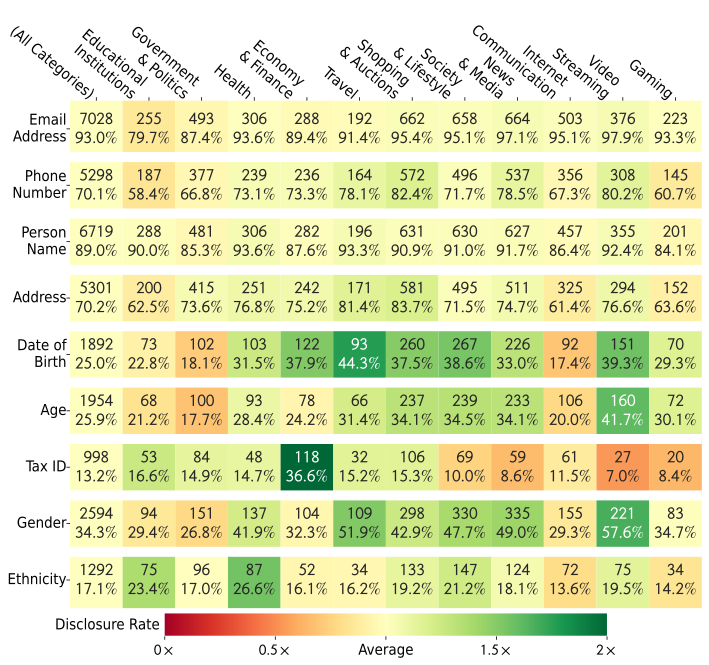

In [14]:
# Disclosure Rate (Figure 6)

SELECTED_WEBSITE_CATEGORIES = """
Gaming
Video Streaming
Internet Communication
News & Media
Society & Lifestyle
Shopping & Auctions
Travel
Economy & Finance
Health
Government & Politics
Educational Institutions
""".strip().split('\n')[::-1]

COMMON_DATA_TYPES = [
    'EmailAddress',
    'PhoneNumber',
    'PersonName',
    'Address',

    'DateOfBirth',
    'AgeOrAgeGroup',

    'TaxId',

    'Gender',
    'Ethnicity',
]

df_domain_count = pd.DataFrame(
    0,
    columns=['All'] + SELECTED_WEBSITE_CATEGORIES,
    index=COMMON_DATA_TYPES,
    dtype=int
)
df_disclose_count = df_domain_count.copy()

for data_type in COMMON_DATA_TYPES:
    disclosed_set = frozenset(df[df.data_types.map(lambda s: data_type in s)].index)

    df_domain_count.at[data_type, 'All'] = df.shape[0]
    df_disclose_count.at[data_type, 'All'] = len(disclosed_set)

    for category in SELECTED_WEBSITE_CATEGORIES:
        subset = df[df.website_category.map(lambda s: category in s)]

        disclosed_set = frozenset(subset[subset.data_types.map(lambda s: data_type in s)].index)

        df_domain_count.at[data_type, category] = subset.shape[0]
        df_disclose_count.at[data_type, category] = len(disclosed_set)

df_stat = df_disclose_count / df_domain_count

df_label = df_stat.astype(str)

for i, j in itertools.product(df_label.index, df_label.columns):
    n_disclose = df_disclose_count.at[i, j]
    rate = df_stat.at[i, j]
    df_label.at[i, j] = f"${n_disclose:d}$\n${rate * 100.0:.1f}\\%$"

fig, ax = plt.subplots(figsize=(10, 10))

g = sns.heatmap(
    #df_stat,
    df_stat.div(df_stat.loc[:, 'All'], axis=0),
    annot=df_label,
    fmt='',
    annot_kws={"fontsize": 17},
    cbar=True,
    cbar_kws=dict(use_gridspec=True, location='bottom', shrink=0.7, pad=0.01),
    #cmap='coolwarm',
    cmap=sns.color_palette("RdYlGn", as_cmap=True),
    vmin=0.0, vmax=2.0,
    #cmap='viridis',
    ax=ax,
    #linewidths=1,
)

for i in range(1, len(COMMON_DATA_TYPES)):
    ax.axhline(i, color='white', linewidth=10)

ax.tick_params(axis='y', which='major', pad=0, labelsize=15)
ax.tick_params(axis='x', which='major', pad=-5, labelsize=15, labelbottom=False, bottom=False, top=True, labeltop=True)

def website_category_rename(website_category):
    if website_category == "All":
        return "(All Categories)"

    website_category = website_category.replace(', and', ' &')
    candidates = [m.start() for m in re.finditer(r'\W+', website_category)]

    if len(candidates) > 0:
        pos = min(candidates, key=lambda x: abs(x * 2 - len(website_category)))
        return website_category[:pos] + '\n' + website_category[pos:]
    else:
        return website_category

DATA_TYPE_MAP = {
    'EmailAddress': 'Email\nAddress',
    'PhoneNumber': 'Phone\nNumber',
    'PersonName': 'Person\nName',
    'Address': 'Address',
    'DateOfBirth': 'Date of\nBirth',
    'AgeOrAgeGroup': 'Age',
    'TaxId': 'Tax ID',
    'Gender': 'Gender',
    'Ethnicity': 'Ethnicity',
}

ax.set_xticklabels(
    [website_category_rename(i.get_text()) for i in ax.get_xticklabels()],
    rotation=-40, ha='right', size=15)
ax.set_yticklabels([DATA_TYPE_MAP[i.get_text()] for i in ax.get_yticklabels()], rotation=0, ha='right', size=15)

cbar = g.collections[0].colorbar
cbar.ax.yaxis.set_label_position('left') 
#cbar.ax.xaxis.tick_top()
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_ylabel('Disclosure Rate', size=15, labelpad=5, rotation=0, ha='right', va='center')
yticks = np.arange(0.0, 2.0 + 1e-6, 0.5)
cbar.ax.set_xticks(yticks)
cbar.ax.set_xticklabels([rf'${i:g}\times$' if i != 1.0 else 'Average' for i in yticks])

plt.savefig('pp_disclosure_heatmap.pdf')

plt.tight_layout()
plt.show()

In [15]:
# Privacy policy statements vs. observed collection (Table 7)

from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

n = df.shape[0]

for data_type in COMMON_DATA_TYPES:
    collected_set = frozenset(df[df.data_types_collected.map(lambda s: data_type in s)].index)
    disclosed_set = frozenset(df[df.data_types.map(lambda s: data_type in s)].index)

    c1d1 = collected_set & disclosed_set
    c1d0 = collected_set - disclosed_set
    c0d1 = disclosed_set - collected_set

    n11 = len(c1d1)
    n10 = len(c1d0)
    n01 = len(c0d1)
    n00 = n - n11 - n10 - n01

    n1x = n11 + n10
    nx1 = n11 + n01
    phi = (n * n11 - n1x * nx1) / np.sqrt(n1x * (n - n1x) * nx1 * (n - nx1))

    table = np.array([[n11, n10], [n01, n00]])
    res = chi2_contingency(table, correction=False)
    phi = association(table, method='pearson')

    print(
        f'{data_type:14s}',
        f'{n11:5,}',
        f'{n10:4,}',
        f'{n11 / (n11 + n10) * 100.0:4.1f}\\%',
        f'{n01:5,}',
        f'{n01 / (n11 + n01) * 100.0:4.1f}\\%',
        round(phi, 3),
        sep=' & ',
        end=' \\\\\n'
    )

EmailAddress   & 6,859 &  504 & 93.2\% &   169 &  2.4\% & 0.026 \\
PhoneNumber    & 2,759 &  822 & 77.0\% & 2,539 & 47.9\% & 0.142 \\
PersonName     & 5,287 &  609 & 89.7\% & 1,432 & 21.3\% & 0.043 \\
Address        & 1,282 &  370 & 77.6\% & 4,019 & 75.8\% & 0.085 \\
DateOfBirth    &   392 &  580 & 40.3\% & 1,500 & 79.3\% & 0.134 \\
AgeOrAgeGroup  &    71 &  125 & 36.2\% & 1,883 & 96.4\% & 0.039 \\
TaxId          &    59 &   58 & 50.4\% &   939 & 94.1\% & 0.137 \\
Gender         &   155 &  176 & 46.8\% & 2,439 & 94.0\% & 0.056 \\
Ethnicity      &    29 &   71 & 29.0\% & 1,263 & 97.8\% & 0.037 \\


In [16]:
# Specific examples (Section 6.2 -- Practices vs. Disclosures)

df_website_data_types = df_forms[~df_forms.form_type.isna()].groupby('domain').agg({
    'website_category': 'first',
    'data_type': lambda s: frozenset.union(*s)
})

df = df_pp.join(df_website_data_types[['data_type']], on='domain', how='inner').rename({'data_type': 'data_types_collected'}, axis=1)

pd.set_option('display.max_colwidth', None)
df[df.index == 'swarovski.com']

,website_category,privacy_policy_urls,data_types,data_types_collected
domain,,,,
swarovski.com,(Society & Lifestyle),"(https://www.swarovski.com/en-US/s-dataprotection/Privacy-Policy/, https://www.swarovski.com/en-US/s-dataprotection/)","(DateOfBirth, BankAccountNumber, EmailAddress, Gender, Address, TaxId, AgeOrAgeGroup, PhoneNumber, PersonName)","(BankAccountNumber, EmailAddress, Password, UsernameOrOtherId, LocationCityOrCoarser, Address, PostalCode, PhoneNumber, PersonName)"


In [17]:
df[df.index == 'redbox.com']

,website_category,privacy_policy_urls,data_types,data_types_collected
domain,,,,
redbox.com,"(Movies, Gaming)","(https://www.redbox.com/privacy, https://redbox.com/privacy)","(DateOfBirth, BankAccountNumber, EmailAddress, Gender, Address, TaxId, AgeOrAgeGroup, Ethnicity, PhoneNumber, PersonName)","(DateOfBirth, EmailAddress, Password, LocationCityOrCoarser, Address, PostalCode, PhoneNumber, PersonName)"
